In [ ]:
#packages
import mat73
import os
from scipy.io import loadmat
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy
import importlib
from skimage import io
from matplotlib import cm
import matplotlib.colors as mcolors
import imageio
import statsmodels.stats.multitest
from tqdm import tqdm
from matplotlib import gridspec
import svglib
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix

#import methods
%run methods_Figure3.ipynb
%run methods_Figure4.ipynb
%run analysis_utils.ipynb
%run methods_behaviourAnalysis.ipynb
%run methods_AllenAnalysis.ipynb
%run methods_segmentedInjections.ipynb


In [ ]:
#this is used to run linear mxied models
import matlab.engine
eng = matlab.engine.start_matlab()

### Define variables for future use

In [ ]:
ops = {}    
ops['areas'] = ['V1','P','POR','LI', 'LM', 'AL','RL','A','AM', 'PM']

ops['mm'] = 0.0393701
ops['myColorsDict'] = {'HVA_colors' : {'V1': '#4A443F', 
                        'POR': '#FF8623', #4C9E57
                        'P': '#FFB845', #AAC255
                        'LI': '#F5501E', #79B855            
                        'LM' : '#EB7C6C',
                        'AL' : '#DB839F',                
                        'RL' : '#BB83DB',
                        'A': '#8172F0',
                        'AM': '#4062F0',
                        'PM': '#6CBEFF',                                                  
                        'OUT': 'lightgray',
                        'ventral': '#FF8623',
                        'dorsal': '#4062F0',
                        'dorso-ventral': '#A161A4'}} #FF8606
ops['dorsal'] = ['AM', 'PM', 'A', 'RL'] 
ops['ventral'] = ['P', 'POR', 'LI', 'LM', 'AL']  
ops['groups'] = ['V1', 'Ventral', 'Dorsal'] 
ops['colors_groups'] = ['#4A443F',ops['myColorsDict']['HVA_colors']['POR'],ops['myColorsDict']['HVA_colors']['AM']] 
ops['color_motor'] = '#FF9D00'
ops['color_stim'] = '#1368F0'
ops['color_full'] = '#C90700'
ops['color_stimSub'] =  '#BF65C9' 
ops['color_motorSub'] = '#008D36'

ops['azimuths'] = ['-108','-90','-72','-54','-36','-18','0','18','36','54','72','90','108']
ops['freq_names'] = ['2', '4', '8', '16', '32', '64']

ops['dataPath'] = os.path.join('Z:', 'home', 'shared', 'Alex_analysis_camp', 'data_axonsPaper')
ops['outputPath'] = os.path.join('Z:', 'home', 'shared', 'Alex_analysis_camp','data_axonsPaper','analysisOutputs')

ops['ref'] = imageio.imread(os.path.join(ops['dataPath'] ,'reference_maps','ReferenceMap_allen_black_nice.png'))
ops['ref2'] = imageio.imread(os.path.join(ops['dataPath'] ,'reference_maps','ReferenceMap_allen_black_nice_uncropped.png'))
ops['map_V1'] = imageio.imread(os.path.join(ops['dataPath'],'reference_maps','Reference_map_allen_V1Marked.png'))
map_colors = imageio.imread(os.path.join(ops['dataPath'],'reference_maps','Reference_map_allen_colors.png'))
ops['map_colors'] = map_colors[:,:,0:3]
ops['colors_LUT'] = np.load(os.path.join(ops['dataPath'],'reference_maps','colorMap_LUT_allen.npy'), allow_pickle = True).item()
       
groups = np.load(os.path.join(ops['dataPath'],'injectionPosition_groups.npy'), allow_pickle=True).item()
ops['ventralAnimals'] = groups['ventralAnimals']
ops['dorsalAnimals'] = groups['dorsalAnimals']
ops['posteriorAnimals'] = groups['posteriorAnimals']
ops['anteriorAnimals'] = groups['anteriorAnimals']

## Figure 3 and associated supplementary plots

### Sound frequency dataset

In [ ]:
df = pd.read_csv(os.path.join(ops['dataPath'],'frequencies_dataset', 'df_freq_peak_axons.csv'))
maps = np.load(os.path.join(ops['dataPath'],'frequencies_dataset', 'maps_freq_green_dataset_all_GLM_motorSub_adj.npy'))
df_fit = np.load(os.path.join(ops['dataPath'],'frequencies_dataset', 'df_fit_frequencies_motorSub_all.npy'), allow_pickle=True).item()

In [ ]:
#quantify proportions of responsive and frequency-tuned 
quantifySignificance_frequencies(df,ops)

In [ ]:
sel_green_freq = np.load(os.path.join(ops['dataPath'],'frequencies_dataset', 'selective_freq_idx_boutons.npy'))
singlePeak, doublePeak = classifyFreqSplines(df_fit['freq_curve'], 0.75)

includeIdx0 = np.intersect1d(sel_green_freq, singlePeak)                       
noArea_idx = np.nonzero(np.array(df['area']) == 'OUT')[0]
includeIdx = np.setdiff1d(includeIdx0, noArea_idx)

df0 = df.iloc[includeIdx] 
maps0 = maps[includeIdx,::]
data0 = df_fit['spline_peak'][includeIdx]

In [ ]:
fig = plt.figure(figsize=(100*ops['mm'], 200*ops['mm']), constrained_layout=False)
plotFreqDistribution_byArea(df0, data0, ops, fig)

In [ ]:
name = 'hierarchicalBootstrap_frequencies_boutons_byArea'

plotHierarchicalBootstrap_FV(name, ops)

In [ ]:
fig = plt.figure(figsize=(100*ops['mm'], 100*ops['mm']), constrained_layout=True)
plotFrequency_bySession(df0, data0, ops,eng,fig)

In [ ]:
plotFreqDistribution_byStream(df0, data0, ops, eng)

In [ ]:
width0 = df_fit['spline_fwhm'][includeIdx]
plotTuningWidth_byArea(df0, width0, ops,eng)

In [ ]:
#Complex tuning
includeIdx0 = sel_green_freq
                             
noArea_idx = np.nonzero(np.array(df['area']) == 'OUT')[0]
includeIdx = np.setdiff1d(includeIdx0, noArea_idx)

doubleIdx = np.intersect1d(doublePeak, includeIdx)

plotProportionComplexFreq(df,includeIdx, doubleIdx, ops, eng)

In [ ]:
includeIdx0 = np.intersect1d(sel_green_freq, singlePeak)                       
noArea_idx = np.nonzero(np.array(df['area']) == 'OUT')[0]
includeIdx = np.setdiff1d(includeIdx0, noArea_idx)

df1 = df.iloc[includeIdx]
si = getSparsityIdx(maps)

plotSparsityIdx_byArea(df1, si[includeIdx], ops, eng)

In [ ]:
resp_green_freq = np.load(os.path.join(ops['dataPath'],'frequencies_dataset', 'responsive_freq_idx_boutons.npy'))

%run methods_Figure3.ipynb
%run analysis_utils.ipynb

df_resp_boutons = df.iloc[resp_green_freq]

plotSignalCorrelation_byArea_FV(df_resp_boutons, ops, computeMatrix =0) #compute matrix loads all pairwise signal correlations, which takes a while

In [ ]:
#Effect of innjection location for supp figures
%run methods_Figure3.ipynb

plotFrequency_againstSource(df0, data0, ops, eng)

### Location tuning dataset

In [ ]:
df = pd.read_csv(os.path.join(ops['dataPath'],'locations_dataset', 'df_coliseum_boutons_final.csv')) #dataframe with info for each roi
%run methods_Figure3.ipynb

quantifySignificance_coliseum_v2(df,ops)

In [ ]:
resp_boutons_idx= np.load(os.path.join(ops['dataPath'], 'locations_dataset','responsive_idx_coliseum_boutons.npy'))
df_resp_axons = df.iloc[resp_boutons_idx]

plotSignalCorrelation_byArea_CS(df_resp_axons, ops, mode = 'all', computeMatrix =0) #compute matrix loads all pairwise signal correlations, which takes a while

In [ ]:
plotSignalCorrelation_byArea_CS(df_resp_axons, ops, mode = 'azi', computeMatrix =0) #compute matrix loads all pairwise signal correlations, which takes a while

In [ ]:
plotSignalCorrelation_byArea_CS(df_resp_axons, ops, mode = 'elev', computeMatrix =0) #compute matrix loads all pairwise signal correlations, which takes a while

In [ ]:
resp_boutons_idx= np.load(os.path.join(ops['dataPath'], 'locations_dataset','responsive_idx_coliseum_boutons.npy'))
axonIdx = np.load(os.path.join(ops['dataPath'], 'locations_dataset','axonIdx_coliseum_motorSub.npy'))
resp_axons_idx = np.intersect1d(resp_boutons_idx, axonIdx)
df_resp_axons = df.iloc[resp_axons_idx]

plotSignalCorrelation_byArea_CS(df_resp_axons, ops, mode = 'axons', computeMatrix =0) #compute matrix loads all pairwise signal correlations, which takes a while

## Figure 4

### Sound azimuth tuning

In [100]:
#Load data
azi_peak_green_aud_full = pd.read_csv(os.path.join(ops['dataPath'],'locations_dataset', 'df_coliseum_boutons_final.csv')) #dataframe with info for each roi
df_fit = np.load(os.path.join(ops['dataPath'],'locations_dataset', 'df_fit_1d_boutons_aud_motorSub.npy'), allow_pickle = True).item() #fit location tuning curves for each bouton
maps_green_aud_motorSub = np.load(os.path.join(ops['dataPath'],'locations_dataset', 'maps_green_audGLM_motorSub.npy')) #average response to each sound location for each axon

#load index of selective boutons
sel_green_aud_azi= np.load(os.path.join(ops['dataPath'],'locations_dataset', 'selective_green_aud_azimuth_maxWilcoxon_a1.npy'))
sel_green_aud_elev =np.load(os.path.join(ops['dataPath'], 'locations_dataset','selective_green_aud_elevation_maxWilcoxon_a1.npy'))

#apply index
df = azi_peak_green_aud_full.iloc[sel_green_aud_azi]
peak = np.array(df_fit['gaussian_peak'])[sel_green_aud_azi]
df['peak'] = peak

gaussFit = np.nonzero(np.array(df_fit['r2_gauss'])[sel_green_aud_azi] >= 0.6)[0]

df0 = df.iloc[gaussFit]
peak0 = peak[gaussFit]

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\989933768.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['peak'] = peak


In [ ]:
#Azimuth tuning distribuion for all boutons
fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100),constrained_layout =True)
ax = fig.add_subplot(1,1,1)
plotAzimuthDistribution(df0, peak0, fig, ax)

In [ ]:
#Azimuth tuning distribution for boutons grouped by visual area
fig = plt.figure(figsize=(100*ops['mm'],200*ops['mm']), constrained_layout=False)
gs = gridspec.GridSpec(5, 2, figure=fig, hspace=0.3, wspace=0.5,left=0.16, right=0.95, bottom=0.1, top=0.95)
plotAzimuthDistribution_byArea(fig, gs, df, gaussFit,peak, ops)

In [ ]:
#Pairwise comparison between distributions (hierarhical bootstrap)
# axonIdx = np.load(os.path.join(ops['dataPath'], 'axonIdx_coliseum_motorSub.npy'))  #boutons grouped into axons based on correlation over time
# sel_axons_green_aud = np.intersect1d(sel_green_aud_azi, axonIdx) 

# df_axons = azi_peak_green_aud_full.iloc[sel_axons_green_aud]
# peak_axons = df_fit['gaussian_peak'][sel_axons_green_aud]
# gaussFit_axons = np.nonzero(np.array(df_fit['r2_gauss'])[sel_axons_green_aud] >= 0.6)[0]

# df_axons['peak'] = peak_axons

# fig = plt.figure(figsize=(ops['mm']*100,100*ops['mm']),constrained_layout = True)
# ax = fig.add_subplot(1,1,1)
# plotHierarchicalBootstrap(fig, ax, df_axons, peak_axons, gaussFit_axons, ops, nBoot= 1000)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:10<00:00,  8.53it/s]


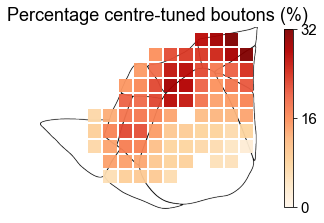

In [98]:
%run methods_Figure4.ipynb

fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
plotProportionCentre_onMap(fig, ops['ref'], ops['ref2'], df0,ops,b=300)

In [ ]:
propCentre_byArea = plotProportionCentre_bySession(df, gaussFit,peak, eng, ops)

C:\Users\egeaa\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\1444705761.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gaussFit['streamIdx'] = t


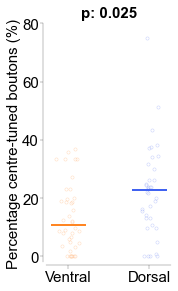

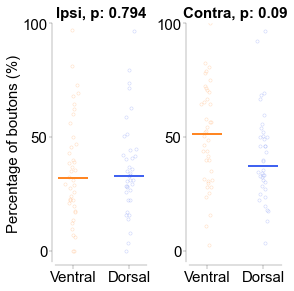

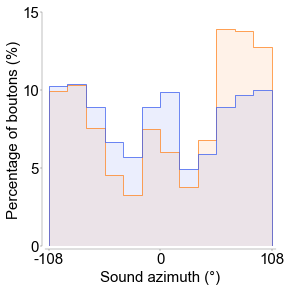

In [103]:
%run methods_Figure4.ipynb

plotProportionCentre_byStream(fig, df,peak,gaussFit,eng,ops)

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\449802713.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['streamIdx'] = t
C:\Users\egeaa\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


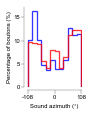

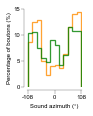

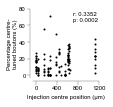

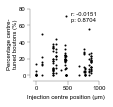

In [105]:
%run methods_Figure4.ipynb
%run analysis_utils.ipynb

exploreInjectionLocation_azimuths(df0, peak0, ops,eng)

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.74it/s]


Text(0.5, 1.0, 'Posterior Injection')

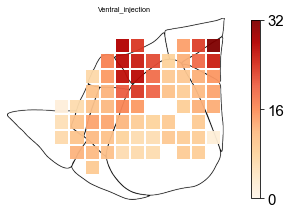

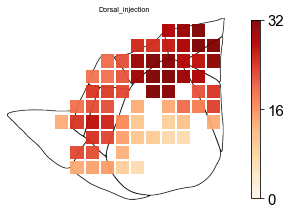

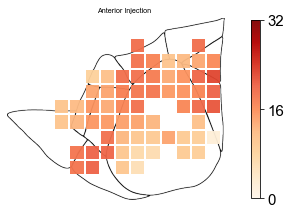

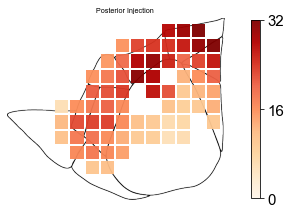

In [106]:
fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
ventral_idx =np.nonzero(np.array([df0['animal'].iloc[i] in ops['ventralAnimals'] for i in range(len(df0))]))[0]
plotProportionCentre_onMap(fig,ops['ref'], ops['ref2'], df0.iloc[ventral_idx],ops,b=300)
plt.title('Ventral_injection')

fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
dorsal_idx =np.nonzero(np.array([df0['animal'].iloc[i] in ops['dorsalAnimals'] for i in range(len(df0))]))[0]
plotProportionCentre_onMap(fig, ops['ref'], ops['ref2'], df0.iloc[dorsal_idx],ops,b=300)
plt.title('Dorsal_injection')

fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
anterior_idx =np.nonzero(np.array([df0['animal'].iloc[i] in ops['anteriorAnimals'] for i in range(len(df0))]))[0]
plotProportionCentre_onMap(fig, ops['ref'], ops['ref2'], df0.iloc[anterior_idx],ops,b=300)
plt.title('Anterior Injection')

fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
posterior_idx =np.nonzero(np.array([df0['animal'].iloc[i] in ops['posteriorAnimals'] for i in range(len(df0))]))[0]
plotProportionCentre_onMap(fig, ops['ref'], ops['ref2'], df0.iloc[posterior_idx],ops,b=300)
plt.title('Posterior Injection')

### Relationship with visual retinotopy

In [112]:
azi_peak_red_vis = pd.read_csv(os.path.join(ops['dataPath'],'locations_dataset', 'df_coliseum_neurons_final.csv'))
sel_red_vis_both = np.load(os.path.join(ops['dataPath'], 'locations_dataset', 'selective_red_vis_motorSub.npy'))
df_red_vis_sig = azi_peak_red_vis.iloc[sel_red_vis_both]
df_red = interpolateAzimuth_coliseum(df_red_vis_sig)

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\3880300108.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['aziPeak'] = data_interp
C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\3880300108.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['elevPeak'] = data_interp


100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:07<00:00, 11.11it/s]


Text(0.5, 1.0, 'Visual azimuth, VC neurons')

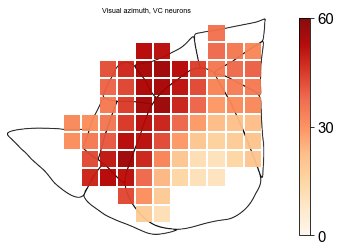

In [113]:
%run methods_Figure4.ipynb

# plotBestAzimuth_red_onMap(fig, df_red, ops['ref'], ops['ref2'],ops['map_V1'], b=300)
plotProportionCentre_onMap_red(fig,ax, ops['ref'], ops['ref2'],ops['map_V1'],df_red, ops,cmap='OrRd', b=300)
plt.title('Visual azimuth, VC neurons')

C:\Users\egeaa\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\195251797.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_bySession_this_sh = np.array([peak_azi_bySession_sh[idx[i]] for i in range(len(idx))])


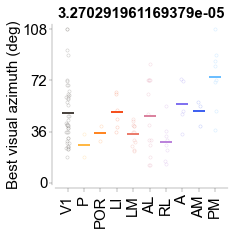

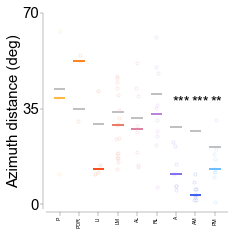

In [114]:
plotAzimuthDistance(df,peak,gaussFit, df_red, ops, eng,nShuffles=100)

100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:07<00:00, 10.97it/s]


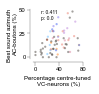

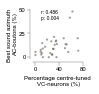

In [122]:
%run methods_Figure4.ipynb

#All VC
plotPropCentre_againstAzi_spatialBins(ops['ref'],ops['map_V1'],df0, df_red, ops,b=300,mask='none',propCentre_green=1, propCentre_red =1)

#V1 only
plotPropCentre_againstAzi_spatialBins(ops['ref'],ops['map_V1'],df0, df_red, ops,b=300,mask='V1',propCentre_green=1, propCentre_red =1)

100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:03<00:00, 24.33it/s]


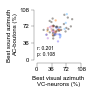

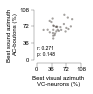

In [121]:
#All VC
plotPropCentre_againstAzi_spatialBins(ops['ref'],ops['map_V1'],df0, df_red, ops,b=300,mask='none',propCentre_green=0, propCentre_red =0)

#V1 only
plotPropCentre_againstAzi_spatialBins(ops['ref'],ops['map_V1'],df0, df_red, ops,b=300,mask='V1',propCentre_green=0, propCentre_red =0)

In [ ]:
#plotAzimuth_acrossMod_matchedFOV(df,peak,gaussFit, df_red,ops,eng)


### Sound elevation tuning

In [123]:
df = azi_peak_green_aud_full.iloc[sel_green_aud_elev]
maps = maps_green_aud_motorSub[sel_green_aud_elev]
peak = np.array(df_fit['gaussian_peak'])[sel_green_aud_elev]

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\3659703171.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_green_elev['elevPeak'] = elevPeak[includeIdx_green_elev]
C:\Users\egeaa\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\3659703171.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_bySession_this_sh = np.array([peak_elev_bySessi

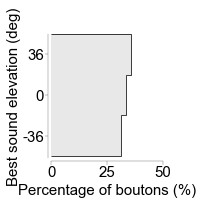

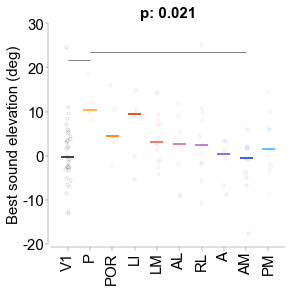

In [124]:
plotElevation_byArea(df,maps,peak,eng,ops, nShuffles=100)

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\1636430905.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_green_elev['elevPeak'] = elevPeak[includeIdx_green_elev]
C:\Users\egeaa\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\1636430905.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['streamIdx'] = t


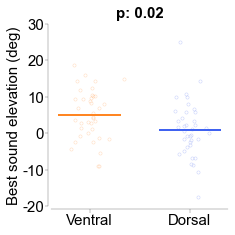

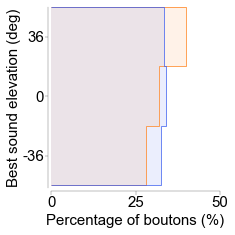

In [125]:
plotElevation_byStream(df, peak, maps, eng, ops)    

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\2415440937.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['peak'] = elev
100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:09<00:00,  9.99it/s]


Text(0.5, 1.0, 'All animals')

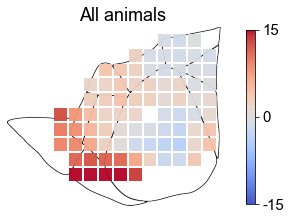

In [126]:
fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
plotBestElevation_onMap(fig, df, maps, peak,ops['ref'], ops['ref2'],ops['map_V1'], b=300)
plt.title('All animals')

100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:07<00:00, 11.09it/s]


Text(0.5, 1.0, 'Visual elevation, VC-neurons')

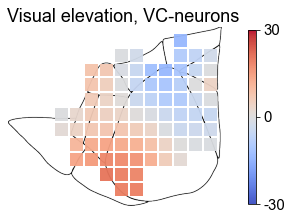

In [127]:
fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
plotBestElevation_red_onMap(fig, df_red, ops['ref'], ops['ref2'],ops['map_V1'], b=300)
plt.title('Visual elevation, VC-neurons')

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\3779314777.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_green_elev['elevPeak'] = elevPeak[includeIdx_green_elev]
C:\Users\egeaa\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\3779314777.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_bySession_this_sh = np.array([peak_elev_bySessio

3.9912993175862863
2.340522435608188
1.8692560984820117
2.7909667438981827
2.4064948240298767
1.6204997784078807
1.0
1.6392210028394247
1.386060864655528


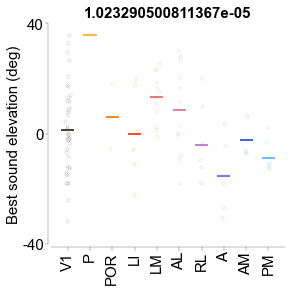

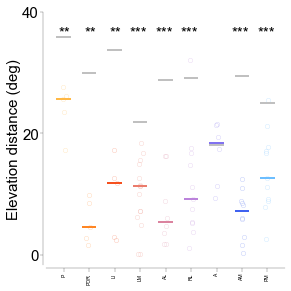

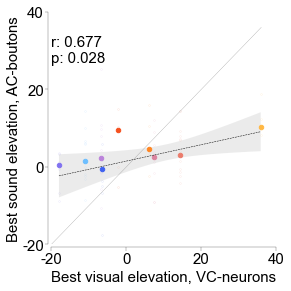

In [128]:
values_green_elev, values_red_elev = plotElevationDistance(df,maps,peak, df_red, ops, eng,nShuffles=1000)    

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\1882814040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['peak'] = elev
100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:07<00:00, 11.04it/s]


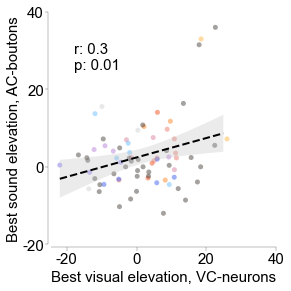

In [129]:
plotElevation_spatialBins_acrossMod(ops['ref'],df, maps, peak,df_red,ops, b=300, mask = 'none') #mask should be 'V1', 'HVAs' or none

C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\365434240.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_green_elev['elevPeak'] = elevPeak[includeIdx_green_elev]
C:\Users\egeaa\AppData\Local\Temp\2\ipykernel_22152\365434240.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['streamIdx'] = t
C:\Users\egeaa\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


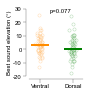

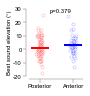

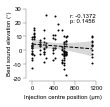

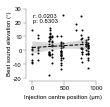

In [130]:
%run methods_Figure4.ipynb

exploreInjectionLocation_elevation(df, peak,maps, ops,eng)

In [ ]:
ventral_idx =np.nonzero(np.array([df['animal'].iloc[i] in ops['ventralAnimals'] for i in range(len(df))]))[0]
dorsal_idx =np.nonzero(np.array([df['animal'].iloc[i] in ops['dorsalAnimals'] for i in range(len(df))]))[0]
anterior_idx =np.nonzero(np.array([df['animal'].iloc[i] in ops['anteriorAnimals'] for i in range(len(df))]))[0]
posterior_idx =np.nonzero(np.array([df['animal'].iloc[i] in ops['posteriorAnimals'] for i in range(len(df))]))[0]

fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
plotBestElevation_onMap(fig, df.iloc[ventral_idx], maps[ventral_idx], peak[ventral_idx], ops['ref'], ops['ref2'],ops['map_V1'],b=300)
plt.title('Ventral_injection')

fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
plotBestElevation_onMap(fig, df.iloc[dorsal_idx], maps[dorsal_idx], peak[dorsal_idx], ops['ref'], ops['ref2'],ops['map_V1'],b=300)
plt.title('Dorsal_injection')

fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
plotBestElevation_onMap(fig, df.iloc[anterior_idx], maps[anterior_idx], peak[anterior_idx], ops['ref'], ops['ref2'],ops['map_V1'],b=300)
plt.title('Anterior_injection')

fig = plt.figure(figsize=(ops['mm']*100, ops['mm']*100), constrained_layout=True)       
plotBestElevation_onMap(fig, df.iloc[posterior_idx], maps[posterior_idx], peak[posterior_idx], ops['ref'], ops['ref2'],ops['map_V1'],b=300)
plt.title('Posterior_injection')


### Facial motion

In [ ]:
%run methods_behaviourAnalysis.ipynb
exampleDataPath = os.path.join(ops['dataPath'], 'exampleData','motion_example')
plotAvgFaceMotion_example(exampleDataPath, ops)

In [ ]:
plotAvgFaceMotion(ops)

In [ ]:
plotFaceMotionDecoders(ops)

### GLM

#### locations

In [ ]:
%run methods_behaviourAnalysis.ipynb

df = pd.read_csv(os.path.join(ops['dataPath'],'locations_dataset', 'df_coliseum_axons_final.csv')) #dataframe with info for each roi
paths0 = np.load(os.path.join(ops['dataPath'],'locations_dataset', 'animalPaths_locations.npy'))
paths = makeDataPaths(os.path.join(ops['dataPath'],'data'),paths0)   
dataset = 'locations'

varExp, modelSig = plotCumulativeDist(df, paths, dataset)

In [ ]:
%run methods_behaviourAnalysis.ipynb

varExp = np.load(os.path.join(ops['dataPath'], 'locations_dataset','varExp_GLM_axons_locations.npy'), allow_pickle=True).item()
plotVarExp_bySession(varExp, ops, dataset)

In [ ]:
sig_GLM = np.load(os.path.join(ops['dataPath'], 'locations_dataset','statistics_GLM_axons_locations.npy'), allow_pickle=True).item()
%run analysis_utils.ipynb
%run methods_behaviourAnalysis.ipynb

plotPropSig_GLM(sig_GLM,ops,dataset)

#### frequencies

In [ ]:
df = pd.read_csv(os.path.join(ops['dataPath'],'frequencies_dataset', 'df_freq_peak_axons.csv')) #dataframe with info for each roi
paths0 = np.load(os.path.join(ops['dataPath'],'frequencies_dataset', 'animalPaths_freqs.npy'))
paths = makeDataPaths(os.path.join(ops['dataPath'],'data'),paths0)   
dataset = 'freqs'

varExp, modelSig = plotCumulativeDist(df, paths, dataset)

In [ ]:
path = paths[108]

plotVarExp_example(path, ops)

In [ ]:
path = paths[108]

plotGLM_traces_example(path, ops)

In [ ]:
%run methods_behaviourAnalysis.ipynb

varExp = np.load(os.path.join(ops['dataPath'], 'frequencies_dataset','varExp_GLM_axons_frequencies.npy'), allow_pickle=True).item()
plotVarExp_bySession(varExp, ops)

In [ ]:
sig_GLM = np.load(os.path.join(ops['dataPath'], 'frequencies_dataset','statistics_GLM_axons_frequencies.npy'), allow_pickle=True).item()
%run analysis_utils.ipynb
%run methods_behaviourAnalysis.ipynb
dataset = 'freqs'

plotPropSig_GLM(sig_GLM,ops,dataset)

### GLM motor subtraction

#### Frequencies dataset

In [ ]:
%run methods_behaviourAnalysis.ipynb

path = paths[108]
plotMotorSub_example(path, ops)

In [ ]:
df = pd.read_csv(os.path.join(ops['dataPath'],'frequencies_dataset', 'df_freq_peak_axons.csv')) #dataframe with info for each roi
paths0 = np.load(os.path.join(ops['dataPath'],'frequencies_dataset', 'animalPaths_freqs.npy'))
paths = makeDataPaths(os.path.join(ops['dataPath'],'data'),paths0)  
%run methods_behaviourAnalysis.ipynb
dataset = 'frequencies'

prop_highVar, prop_highVar_stimSub, prop_highVar_motorSub = getMotorSub_vars(df, paths)

In [ ]:
p_loc, p_face = plotMotorSub_quantification(prop_highVar, prop_highVar_stimSub, prop_highVar_motorSub, ops, dataset)

In [ ]:
p_face

In [ ]:
%run methods_behaviourAnalysis.ipynb

df = pd.read_csv(os.path.join(ops['dataPath'],'frequencies_dataset', 'df_freq_peak_axons.csv')) #dataframe with info for each roi
plotResp_motorSub_freq(df, ops)

In [ ]:
%run methods_behaviourAnalysis.ipynb

df = pd.read_csv(os.path.join(ops['dataPath'],'frequencies_dataset', 'df_freq_peak_axons.csv')) #dataframe with info for each roi
plotFrequencyChange(df, ops)

#### Locations dataset

In [ ]:
df = pd.read_csv(os.path.join(ops['dataPath'],'locations_dataset', 'df_coliseum_axons_final.csv')) #dataframe with info for each roi
paths0 = np.load(os.path.join(ops['dataPath'],'locations_dataset', 'animalPaths_locations.npy'))
paths = makeDataPaths(os.path.join(ops['dataPath'],'data'),paths0)   
dataset = 'locations'

%run methods_behaviourAnalysis.ipynb

prop_highVar, prop_highVar_stimSub, prop_highVar_motorSub = getMotorSub_vars(df, paths)

In [ ]:
p_loc, p_face = plotMotorSub_quantification(prop_highVar, prop_highVar_stimSub, prop_highVar_motorSub, ops, dataset)

In [ ]:
p_face

In [ ]:
df = pd.read_csv(os.path.join(ops['dataPath'],'locations_dataset', 'df_coliseum_axons_final.csv')) #dataframe with info for each roi
dataset = 'locations'
%run methods_behaviourAnalysis.ipynb

plotResp_motorSub_locations(df, ops)

In [ ]:
%run methods_behaviourAnalysis.ipynb

plotLocationChange(df, ops)

### Allen Injections Analysis

In [ ]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from pathlib import Path

#useful
#https://allensdk.readthedocs.io/en/stable/_static/examples/nb/mouse_connectivity.html
outputPath = os.path.join(ops['dataPath'], 'Allen_connectivity_analysis')

#get df with all experiments
mcc = MouseConnectivityCache(manifest_file=Path(outputPath) / 'manifest.json')
rsp = mcc.get_reference_space()
structure_tree = mcc.get_structure_tree()
all_experiments = mcc.get_experiments(dataframe=True)

idx =[]
for i in range(len(all_experiments)):
    if 'AUD'in all_experiments['structure_abbrev'].iloc[i]:
        idx.append(i)

Ac_exp = all_experiments.iloc[np.array(idx)]

In [ ]:
%run methods_AllenAnalysis.ipynb

final_ids = [100149109, 116903230,120491896,146858006, 184159706,182090318,569994739,112881858,287223629]#criteria for choosing these can be found in manuscript methods

idx = np.array([np.nonzero(np.array(Ac_exp['id']) == final_ids[j])[0] for j in range(len(final_ids))])
df = Ac_exp.iloc[np.squeeze(idx)]

intensity_byArea_all = getProjectionIntensity(final_ids, df,ops,mcc,rsp,structure_tree)

In [ ]:
plotProjectionStrength(df,intensity_byArea_all, ops)

In [ ]:
plotProjectionIntensity_onCortex(df, ops)

### Injection location analysis

In [ ]:
animals = [107, 109, 112, 113,128, 131, 132, 149, 151, 153, 154, 166, 168, 170, 171, 178]
regionNames = ['Primary', 'Ventral','Posterior','Temporal association','Dorsal', 'Ectorhinal','Field CA1', 'visual']

%run analysis_utils.ipynb
%run methods_segmentedInjections.ipynb

plotInjectionPercentages(animals, regionNames, ops)

In [ ]:
%run methods_segmentedInjections.ipynb

plotInjectionlocation(animals,ops)